In [18]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import time
from astropy.table import Table,vstack
from astropy.io import fits
import scipy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib as mpl

def flux2luminosity(flux):
    Flux = flux*u.erg/u.s/(u.cm)**2
    R = 761*u.kpc
    Luminosity = Flux*4*np.pi*R**2
    return Luminosity.to(u.erg/u.s).value
def luminosity2flux(luminosity):
    Luminosity = luminosity*u.erg/u.s
    R = 761*u.kpc
    Flux = Luminosity/(4*np.pi*R**2)
    return Flux.to(u.erg/u.s/(u.cm)**2).value

from astropy.wcs import WCS
from scipy import interpolate




def filter_source_on_Sensmap(SourceFlux,SkyCoord,Sensmap,Mask=None):
    
#     sensmap_file = 'data/snsmap_EP_02000_04500_ML1.fits'
    # detmsk_file = '/Users/rhuang/Data/XMM/M31_data/edetect_stack/edetect_stack_v8_South_for_simulation/detmskM1.fits.gz'
    sensmap_image = fits.getdata(Sensmap)
    sensmap_header = fits.getheader(Sensmap)
    if Mask!=None:
        region_mask = fits.getdata(Mask)
        sensmap_image[region_mask==0]=-2
    detmsk_image = sensmap_image==-2
    sensmap_image[sensmap_image==-2]=1e6
    w = WCS(sensmap_header)
    pixel_x,pixel_y = w.world_to_pixel(SkyCoord)
    pixel_x_floor = np.int_(np.floor(pixel_x))
    pixel_y_floor = np.int_(np.floor(pixel_y))
    mask_index = SourceFlux>sensmap_image[pixel_y_floor,pixel_x_floor]
    # print(np.sum(mask_index))
    return SourceFlux[mask_index]

    
def skyarea_function_from_sensmap(Sensmap,Mask=None,bins=np.logspace(-20,-10,301),cutoff=0.1,plot=False ):
    # cutoff is the cutoff fraction of the skyarea as the sensitivity limit
    sensmap_image = fits.getdata(Sensmap)
    sensmap_header = fits.getheader(Sensmap)
    if Mask!=None:
        region_mask = fits.getdata(Mask)
        sensmap_image[region_mask==0]=-2
    detmsk_image = sensmap_image==-2
    w = WCS(sensmap_header)
    sky_area = w.proj_plane_pixel_area()*np.sum(sensmap_image>0)
    counts,bins=np.histogram(sensmap_image[sensmap_image>0],bins=bins, )
    sky_area_function = np.cumsum(counts)*w.proj_plane_pixel_area()
#     log_bins = np.log10(bins)
#     log_bins_mean = (log_bins[:-1]+log_bins[1:])/2.
#     FluxBins = 10**(log_bins_mean)
#     FluxBins = np.sqrt(bins[:-1] * bins[1:])
    FluxBins = bins[:-1]
    cutoff_sensitivity = FluxBins[sky_area_function<np.max(sky_area_function)*cutoff][-1]
#     print('cutoff_sensitivity',cutoff_sensitivity) 
    if plot==True:
#         plt.axvline(cutoff_sensitivity,linestyle='--')
        plt.plot(FluxBins,sky_area_function)
        plt.xscale('log')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$area~\mathrm{(deg^{2})}$')
    return FluxBins,sky_area_function,cutoff_sensitivity

def get_weight_from_sky_area_function(SourceFlux,Sensmap,Mask=None,bins=np.logspace(-20,-10,301)):
    FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=bins)
    f=interpolate.interp1d(FluxBins,sky_area_function,kind='linear')
    try:
        weight = 1./f(SourceFlux)
    except:
        weight = 1./f(SourceFlux.value.data)
    return weight
    
def sub_get_luminosity_function(SourceFlux,weight,bins,plot=False):
    # 需要选择好的 source flux
    # 需要 skyarea_function
    # 然后可以比较两种不同的计算方法？ 
    N,bins = np.histogram(SourceFlux, bins=bins,weights=weight)
    if plot==True:
        counts,bins,_  =plt.hist(SourceFlux, bins=bins, weights=weight,cumulative=-1,histtype='step')
        plt.xscale('log')
        plt.yscale('log')
        # plt.xlabel('EP_4_FLUX')
        plt.xlabel(r'$S~\mathrm{(ergs~s^{-1}~cm^{-2})} $')
        plt.ylabel('$\mathrm{N(>S)/area~(deg^{-2})}$')    
    return N,bins


def luminosity_function(SourceFlux,Skycoord,Sensmap,Mask=None,color='k',bins=np.logspace(-20,-10,301),cutoff=0.1,plot=True):
    print('Sensmap:',Sensmap)
    print('Mask:',Mask)
    print('Source Num:',len(SourceFlux))
    Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
    print('Remained Source Num:',len(Filtered_SourceFlux))
    FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=bins,cutoff=cutoff,plot=False)
    print(f'Sensitivity limit: {cutoff_sensitivity:.3e}')
    # plt.show()
    weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
    dN,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight)
    N = np.cumsum(dN[::-1])[::-1]
    square_dN_err,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight**2)
    square_N_err = np.cumsum(square_dN_err[::-1])[::-1]
    N_err = np.sqrt(square_N_err)
    index = (FluxBins>cutoff_sensitivity) & (N>0)
    if plot==True:
        # N,bins,_  =plt.hist(Filtered_SourceFlux, bins=bins, weights=weight,cumulative=-1,histtype='step')
#         plt.stairs(N[bins[:-1]>cutoff_sensitivity],bins[bins>cutoff_sensitivity])
#         plt.step(FluxBins[FluxBins>cutoff_sensitivity],N[FluxBins>cutoff_sensitivity],where='pre')
        
#         plt.stairs(N,bins)
#         plt.step(FluxBins[index],N[index],where='pre')
        plt.step(FluxBins[index],N[index],where='mid',color=color)
        plt.errorbar(x=FluxBins[index],y=N[index],yerr=N_err[index],color=color,fmt='none')
        plt.xscale('log')
        plt.yscale('log')
        # plt.xlabel('EP_4_FLUX')
        plt.xlabel(r'$S~\mathrm{(ergs~s^{-1}~cm^{-2})} $')
        plt.ylabel('$N(>S)/area~\mathrm{(deg^{-2})}$')    
        plt.gca().set_ylim(ymin=np.min(N[index])*0.5)
    return FluxBins[index],N[index],N_err[index]


def luminosity_function_dict(SourceFlux,Skycoord,Sensmap,Mask=None,color='k',bins=np.logspace(-20,-10,301),cutoff=0.1,plot=True):
    print('Sensmap:',Sensmap)
    print('Mask:',Mask)
    print('Source Num:',len(SourceFlux))
    Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
    print('Remained Source Num:',len(Filtered_SourceFlux))
    FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=bins,cutoff=cutoff,plot=False)
    print(f'Sensitivity limit: {cutoff_sensitivity:.3e}')
    # plt.show()
    weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
    dN,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight)
    dS = bins[1:]-bins[:-1]
    N = np.cumsum(dN[::-1])[::-1]
    square_dN_err,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight**2)
    square_N_err = np.cumsum(square_dN_err[::-1])[::-1]
    N_err = np.sqrt(square_N_err)
    index = (FluxBins>cutoff_sensitivity) & (N>0)
    if plot==True:
        # N,bins,_  =plt.hist(Filtered_SourceFlux, bins=bins, weights=weight,cumulative=-1,histtype='step')
#         plt.stairs(N[bins[:-1]>cutoff_sensitivity],bins[bins>cutoff_sensitivity])
#         plt.step(FluxBins[FluxBins>cutoff_sensitivity],N[FluxBins>cutoff_sensitivity],where='pre')
        
#         plt.stairs(N,bins)
#         plt.step(FluxBins[index],N[index],where='pre')
        plt.step(FluxBins[index],N[index],where='mid',color=color)
        plt.errorbar(x=FluxBins[index],y=N[index],yerr=N_err[index],color=color,fmt='none')
        plt.xscale('log')
        plt.yscale('log')
        # plt.xlabel('EP_4_FLUX')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$N(>S)/area~\mathrm{(deg^{-2})}$')    
        plt.gca().set_ylim(ymin=np.min(N[index])*0.5)
    return {'S':FluxBins,'N':N,'Nerr':N_err,'dN':dN,'dNerr':np.sqrt(square_dN_err),'bins':bins,'dS':dS,'cutoff':cutoff_sensitivity,'sky_area':sky_area_function[-1]}

def luminosity_function_SNR_dict(SourceFlux,Skycoord,Sensmap,Mask=None,color='k',bins=np.logspace(-20,-10,301),cutoff=0.1,minN=10,plot=True):
    print('Sensmap:',Sensmap)
    print('Mask:',Mask)
    print('Source Num:',len(SourceFlux))
    Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
    print('Remained Source Num:',len(Filtered_SourceFlux))
    if len(Filtered_SourceFlux)<minN:
        bins=np.logspace(-20,-10,41)
        return luminosity_function_dict(SourceFlux,Skycoord,Sensmap,Mask=Mask,color=color,bins=bins,cutoff=cutoff,plot=plot)
    FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=bins,cutoff=cutoff,plot=False)
    print(f'Sensitivity limit: {cutoff_sensitivity:.3e}')
    print(f'minimum counts per bin: {minN}')
    # plt.show()
    weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
    dN,bins = np.histogram(Filtered_SourceFlux, bins=bins)
    ## rebin the data to get a least minN counts
    new_bins = []
    new_counts = []
    count = 0
    bin_sum = 0
    ########## Loop through original bins and counts ##########
    # Find the last non-zero bin
    i = len(dN) - 1
    while i >= 0 and dN[i] == 0:
        i -= 1
    # Initialize variables
    new_bins = [bins[i+1]]
    new_counts = []
    count = dN[i]
    # Loop through remaining bins and counts, in reverse order
    for j in range(i-1, -1, -1):
        count += dN[j]
        # If count exceeds 10, add a new bin
        if count >= minN:
            new_bins.append(bins[j])
            count = 0

    # Add the first non-zero bin
    new_bins.append(bins[0])
    # Reverse the order of the new bins and counts
    new_bins = new_bins[::-1]
    # Convert to numpy arrays
    new_bins = np.array(new_bins)
    ############################################################
    dN,bins = np.histogram(Filtered_SourceFlux, bins=new_bins,weights=weight)
    dS = bins[1:]-bins[:-1]
    N = np.cumsum(dN[::-1])[::-1]
    square_dN_err,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight**2)
    square_N_err = np.cumsum(square_dN_err[::-1])[::-1]
    N_err = np.sqrt(square_N_err)
    ### FluxBins
#     log_bins = np.log10(bins)
#     log_bins_mean = (log_bins[:-1]+log_bins[1:])/2.
#     FluxBins = 10**(log_bins_mean)
#     FluxBins = np.sqrt(bins[:-1] * bins[1:])
    FluxBins = bins[:-1]
    ### 
    index = (FluxBins>cutoff_sensitivity) & (N>0)
    if plot==True:
        # N,bins,_  =plt.hist(Filtered_SourceFlux, bins=bins, weights=weight,cumulative=-1,histtype='step')
#         plt.stairs(N[bins[:-1]>cutoff_sensitivity],bins[bins>cutoff_sensitivity])
#         plt.step(FluxBins[FluxBins>cutoff_sensitivity],N[FluxBins>cutoff_sensitivity],where='pre')
        
#         plt.stairs(N,bins)
#         plt.step(FluxBins[index],N[index],where='pre')
        plt.step(FluxBins[index],N[index],where='mid',color=color)
        plt.errorbar(x=FluxBins[index],y=N[index],yerr=N_err[index],color=color,fmt='none')
        plt.xscale('log')
        plt.yscale('log')
        # plt.xlabel('EP_4_FLUX')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$N(>S)/area~\mathrm{(deg^{-2})}$')    
        plt.gca().set_ylim(ymin=np.min(N[index])*0.5)
    return {'S':FluxBins,'N':N,'Nerr':N_err,'dN':dN,'dNerr':np.sqrt(square_dN_err),'bins':bins,'dS':dS,'cutoff':cutoff_sensitivity,'sky_area':sky_area_function[-1]}






In [22]:
def mass_function(Sensmap,Mask=None,MassMap=None,bins=np.logspace(-20,-10,301),cutoff=0.1,plot=False ):
    # cutoff is the cutoff fraction of the skyarea as the sensitivity limit
    # the origin skyarea_function_from_sensmap is used to calculate how much area is above the flux
    # now the skyarea_function_from_sensmap_with_massmap is used to calculate how much stellar mass is above the flux.
    
    sensmap_image = fits.getdata(Sensmap)
    sensmap_header = fits.getheader(Sensmap)
    massmap_image = fits.getdata(MassMap)
    if Mask!=None:
        region_mask = fits.getdata(Mask)
        sensmap_image[region_mask==0]=-2
    detmsk_image = sensmap_image==-2
    w = WCS(sensmap_header)
    sky_area = w.proj_plane_pixel_area()*np.sum(sensmap_image>0)
    counts,bins=np.histogram(sensmap_image[sensmap_image>0],weights=massmap_image[sensmap_image>0],bins=bins, )
    mass_function = np.cumsum(counts)#*w.proj_plane_pixel_area()
#     log_bins = np.log10(bins)
#     log_bins_mean = (log_bins[:-1]+log_bins[1:])/2.
#     FluxBins = 10**(log_bins_mean)
#     FluxBins = np.sqrt(bins[:-1] * bins[1:])
    FluxBins = bins[:-1]
    print(np.max(mass_function))
    # if np.max(mass_function)==0:
    #     cutoff_sensitivity = np.nan
    # else:
    #     cutoff_sensitivity = FluxBins[mass_function<np.max(mass_function)*cutoff][-1]
#     print('cutoff_sensitivity',cutoff_sensitivity) 
    if plot==True:
#         plt.axvline(cutoff_sensitivity,linestyle='--')
        plt.plot(FluxBins,mass_function)
        plt.xscale('log')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$stellar mass~\mathrm{10^{10}~(M_{\odot})}$')
    return FluxBins,mass_function

def SFR_function(Sensmap,Mask=None,SFRMap=None,bins=np.logspace(-20,-10,301),cutoff=0.1,plot=False ):
    # cutoff is the cutoff fraction of the skyarea as the sensitivity limit
    # the origin skyarea_function_from_sensmap is used to calculate how much area is above the flux
    # now the skyarea_function_from_sensmap_with_massmap is used to calculate how much stellar mass is above the flux.
    
    sensmap_image = fits.getdata(Sensmap)
    sensmap_header = fits.getheader(Sensmap)
    SFRmap_image = fits.getdata(SFRMap)
    if Mask!=None:
        region_mask = fits.getdata(Mask)
        sensmap_image[region_mask==0]=-2
    detmsk_image = sensmap_image==-2
    w = WCS(sensmap_header)
    sky_area = w.proj_plane_pixel_area()*np.sum(sensmap_image>0)
    counts,bins=np.histogram(sensmap_image[sensmap_image>0],weights=SFRmap_image[sensmap_image>0],bins=bins, )
    SFR_function = np.cumsum(counts)#*w.proj_plane_pixel_area()
#     log_bins = np.log10(bins)
#     log_bins_mean = (log_bins[:-1]+log_bins[1:])/2.
#     FluxBins = 10**(log_bins_mean)
#     FluxBins = np.sqrt(bins[:-1] * bins[1:])
    FluxBins = bins[:-1]
    print(np.max(SFR_function))
    # if np.max(mass_function)==0:
    #     cutoff_sensitivity = np.nan
    # else:
    #     cutoff_sensitivity = FluxBins[mass_function<np.max(mass_function)*cutoff][-1]
#     print('cutoff_sensitivity',cutoff_sensitivity) 
    if plot==True:
#         plt.axvline(cutoff_sensitivity,linestyle='--')
        plt.plot(FluxBins,SFR_function)
        plt.xscale('log')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$SFR$')
    return FluxBins,SFR_function


In [19]:
def luminosity_function_dict_v2(SourceFlux,Skycoord,Sensmap,Mask=None,color='k',binsize=60,cutoff=0.1,plot=True):
    bins=np.logspace(-20,-10,binsize+1)
    print('BinSize:',binsize)
    print('Sensmap:',Sensmap)
    print('Mask:',Mask)
    print('Source Num:',len(SourceFlux))
    Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
    print('Remained Source Num:',len(Filtered_SourceFlux))
    FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=bins,cutoff=cutoff,plot=False)
    print(f'Sensitivity limit: {cutoff_sensitivity:.3e}')
    # plt.show()
    weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,10*binsize+1))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
    dN,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight)
    dS = bins[1:]-bins[:-1]
    N = np.cumsum(dN[::-1])[::-1]
    square_dN_err,bins = np.histogram(Filtered_SourceFlux, bins=bins,weights=weight**2)
    square_N_err = np.cumsum(square_dN_err[::-1])[::-1]
    N_err = np.sqrt(square_N_err)
    index = (FluxBins>cutoff_sensitivity) & (N>0)
    
    raw_dN,bins = np.histogram(Filtered_SourceFlux, bins=bins)
    raw_N = np.cumsum(raw_dN[::-1])[::-1]
    raw_dN_err = np.sqrt(raw_dN)
    raw_N_err = np.sqrt(raw_N)
    
    if plot==True:
        # N,bins,_  =plt.hist(Filtered_SourceFlux, bins=bins, weights=weight,cumulative=-1,histtype='step')
#         plt.stairs(N[bins[:-1]>cutoff_sensitivity],bins[bins>cutoff_sensitivity])
#         plt.step(FluxBins[FluxBins>cutoff_sensitivity],N[FluxBins>cutoff_sensitivity],where='pre')
        
#         plt.stairs(N,bins)
#         plt.step(FluxBins[index],N[index],where='pre')
        plt.step(FluxBins[index],N[index],where='mid',color=color)
        plt.errorbar(x=FluxBins[index],y=N[index],yerr=N_err[index],color=color,fmt='none')
        plt.xscale('log')
        plt.yscale('log')
        # plt.xlabel('EP_4_FLUX')
        plt.xlabel('$S~\mathrm{(ergs~s^{-1}~cm^{-2})}$')
        plt.ylabel('$N(>S)/area~\mathrm{(deg^{-2})}$')    
        plt.gca().set_ylim(ymin=np.min(N[index])*0.5)
    return {'S':FluxBins,'N':N,'Nerr':N_err,'dN':dN,'dNerr':np.sqrt(square_dN_err),'bins':bins,'dS':dS,'cutoff':cutoff_sensitivity,'sky_area':sky_area_function[-1]}


之前用的 对每个 source 进行 weight 是很准确的， 那么现在就是要给一个 model， 然后 尝试 给这个model 上个每个source也来加个权重？ 
这个方法不合适。 
但是可以尝试给model用不同的 bins， 分辨率更高的bin， 比如20 倍这样，之后就可以通过 rebin 得到 model expected 的 source number 是多少了。

ok， 这也不失为一个方式。 

那现在就是这样，  使用输入的 bins, 然后用扩展的 bins size， 得到一个新的 area 的 x. 后面就是我要尝试利用model的事情了。 


需要有分辨率 N, area, N/area, dN, dS, S,  
correction function.

uncorrected N
corrected N

所以是要有 dN, 然后有 相应的面积，无论是多少 source 吧。


Sensmap: data/snsmap_EP_02000_04500_ML6.fits.gz
Mask: data/MskMap_Disk.fits.gz
Source Num: 4506
(4506,)
(4506,)
(2, 4506, 4500)
1229
Remained Source Num: 1229
Sensitivity limit: 1.000e-15
minimum counts per bin: 0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 52287.505046 from DATE-END'. [astropy.wcs.wcs]


Sensmap: data/snsmap_EP_02000_04500_ML6.fits.gz
Mask: data/MskMap_Arm_sSFR0-0.02.fits.gz
Source Num: 4506


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 52287.505046 from DATE-END'. [astropy.wcs.wcs]


(4506,)
(4506,)
(2, 4506, 4500)
286
Remained Source Num: 286
Sensitivity limit: 7.943e-16
minimum counts per bin: 0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 52287.505046 from DATE-END'. [astropy.wcs.wcs]


Sensmap: data/snsmap_EP_02000_04500_ML6.fits.gz
Mask: data/MskMap_Arm_sSFR0.02-.fits.gz
Source Num: 4506


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 52287.505046 from DATE-END'. [astropy.wcs.wcs]


(4506,)
(4506,)
(2, 4506, 4500)
281
Remained Source Num: 281
Sensitivity limit: 7.943e-16
minimum counts per bin: 0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 52287.505046 from DATE-END'. [astropy.wcs.wcs]


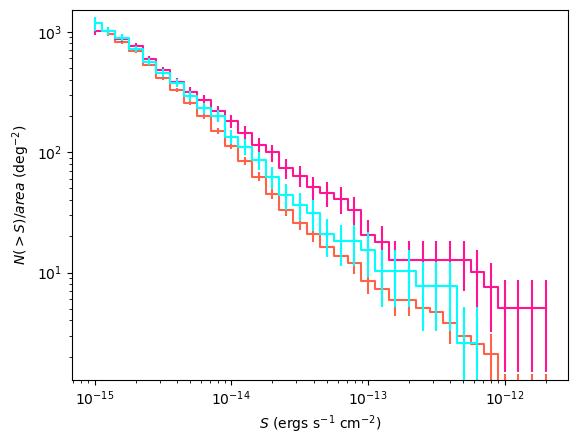

In [20]:

import seaborn as sns
icefire = sns.color_palette("icefire",8)
colors = [icefire[0],icefire[2],icefire[6],icefire[-1]]
EnergyRange = ['00200_00500','00500_01000','01000_02000','02000_04500','04500_12000']

Identification = Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_v6_identification_V3.fits')
# table_with_identification  = Table.read('1.srclist_sum_table_expanded_fix0flux_slim_v6_identification_v3.fits')

Band=4
bins = np.logspace(-16,-10,61)
Sensmap = f'data/snsmap_EP_{EnergyRange[Band-1]}_ML6.fits.gz'
XLF_Data_band = {}
Source = Identification  
SourceFlux = Source[f'EP_{Band}_FLUX']
Source_coordinate = SkyCoord(ra=Source['RA'],dec=Source['DEC'],unit=u.deg,frame='fk5' )
# RegionMask = 'data/MskMap_Center.fits'
# XLF_Data_band['Center']=luminosity_function_SNR_dict(SourceFlux,Source_coordinate,Sensmap,RegionMask,bins=bins,cutoff=0.05,minN=0,plot=True,color='black')    
RegionMask = 'data/MskMap_Disk.fits.gz'
XLF_Data_band['Disk']=luminosity_function_SNR_dict(SourceFlux,Source_coordinate,Sensmap,RegionMask,bins=bins,cutoff=0.05,minN=0,plot=True,color='tomato')    
RegionMask = 'data/MskMap_Arm_sSFR0-0.02.fits.gz'
XLF_Data_band['Arm0-2']=luminosity_function_SNR_dict(SourceFlux,Source_coordinate,Sensmap,RegionMask,bins=bins,cutoff=0.05,minN=0,plot=True,color='deeppink',)    
RegionMask = 'data/MskMap_Arm_sSFR0.02-.fits.gz'
XLF_Data_band['Arm2-']=luminosity_function_SNR_dict(SourceFlux,Source_coordinate,Sensmap,RegionMask,bins=bins,cutoff=0.05,minN=0,plot=True,color='cyan',)    



In [10]:
sensmap_image = fits.getdata(f'data/snsmap_EP_{EnergyRange[Band-1]}_ML6.fits.gz')

In [11]:
sensmap_image[[1,2],[3,2]]

array([-2., -2.], dtype='>f8')